In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 68

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [7]:
NUM_CLASSES = 10

# Dataset reading

In [3]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 43)))

In [4]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/200


100/107 [===========================>..] - ETA: 0s - loss: 2.0440 - accuracy: 0.2751
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5


d:\Projects\VocalWave\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 4s 9ms/step - loss: 2.0232 - accuracy: 0.2842 - val_loss: 1.5979 - val_accuracy: 0.5604
Epoch 2/200
 83/107 [======================>.......] - ETA: 0s - loss: 1.5144 - accuracy: 0.4491
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
107/107 [==============================] - 0s 3ms/step - loss: 1.4705 - accuracy: 0.4592 - val_loss: 1.0675 - val_accuracy: 0.6637
Epoch 3/200
 82/107 [=====================>........] - ETA: 0s - loss: 1.1924 - accuracy: 0.5403
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
107/107 [==============================] - 0s 3ms/step - loss: 1.1696 - accuracy: 0.5497 - val_loss: 0.8359 - val_accuracy: 0.7668
Epoch 4/200
 90/107 [========================>.....] - ETA: 0s - loss: 1.0341 - accuracy: 0.5931
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
107/107 [==============================] - 0s 2ms/step - loss: 1.0240 - accuracy: 0.5979

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

27/27 [==============================] - 0s 2ms/step - loss: 0.1337 - accuracy: 0.9605


In [13]:
# Loading the saved model
# model = tf.keras.models.load_model(model_save_path)

# Confusion matrix

107/107 [==============================] - 0s 1ms/step


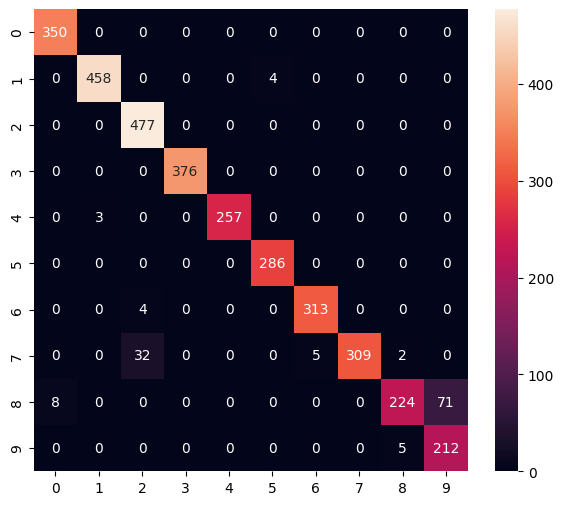

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       350
           1       0.99      0.99      0.99       462
           2       0.93      1.00      0.96       477
           3       1.00      1.00      1.00       376
           4       1.00      0.99      0.99       260
           5       0.99      1.00      0.99       286
           6       0.98      0.99      0.99       317
           7       1.00      0.89      0.94       348
           8       0.97      0.74      0.84       303
           9       0.75      0.98      0.85       217

    accuracy                           0.96      3396
   macro avg       0.96      0.96      0.95      3396
weighted avg       0.97      0.96      0.96      3396



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [15]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

d:\Projects\VocalWave\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)